## Transverse field Ising model to demo primitives

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp

In [5]:
SYGate = UnitaryGate(YGate().power(1/2),label = r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(),label = r"$\sqrt{Y}^\dag$")


def generate_1D_tfin_im(num_qubits,num_trotter_steps, rx_angle, num_cl_bits = 0, trotter_barriers = False, layer_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    for trotter_step in range(num_trotter_steps):
        add_1D_tfin_trotter_layer(qc,rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_1D_tfin_trotter_layer(qc,rx_angle,layer_barriers = False):
    #Adding Rzz in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.sdg([i,i+1])
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()
    #Adding Rzz in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.sdg([i,i+1])
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
    if layer_barriers:
        qc.barrier()

    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
        
    

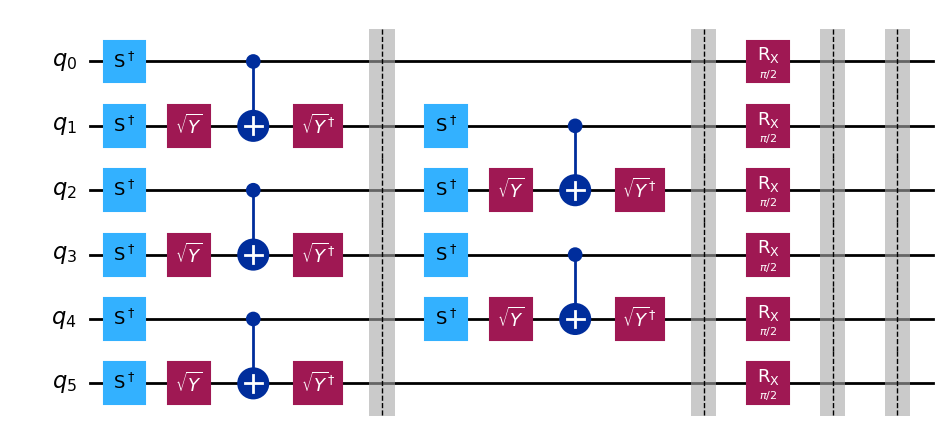

In [6]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5*np.pi

qc = generate_1D_tfin_im(num_qubits,num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
qc.draw(output = "mpl")

In [7]:
def add_miirored_1D_tfin_im(qc, num_qubits,num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):
    for trotter_step in range(num_trotter_steps):
        add_mirrored_1D_tfin_trotter_layer(qc,rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

def add_mirrored_1D_tfin_trotter_layer(qc,rx_angle,layer_barriers = False):
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    #Adding Rzz in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
        qc.s([i,i+1])
    if layer_barriers:
        qc.barrier()
    #Adding Rzz in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.append(SYGate,[i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate,[i+1])
        qc.s([i,i+1])
    if layer_barriers:
        qc.barrier()

add_miirored_1D_tfin_im(qc, num_qubits,num_trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
    

  

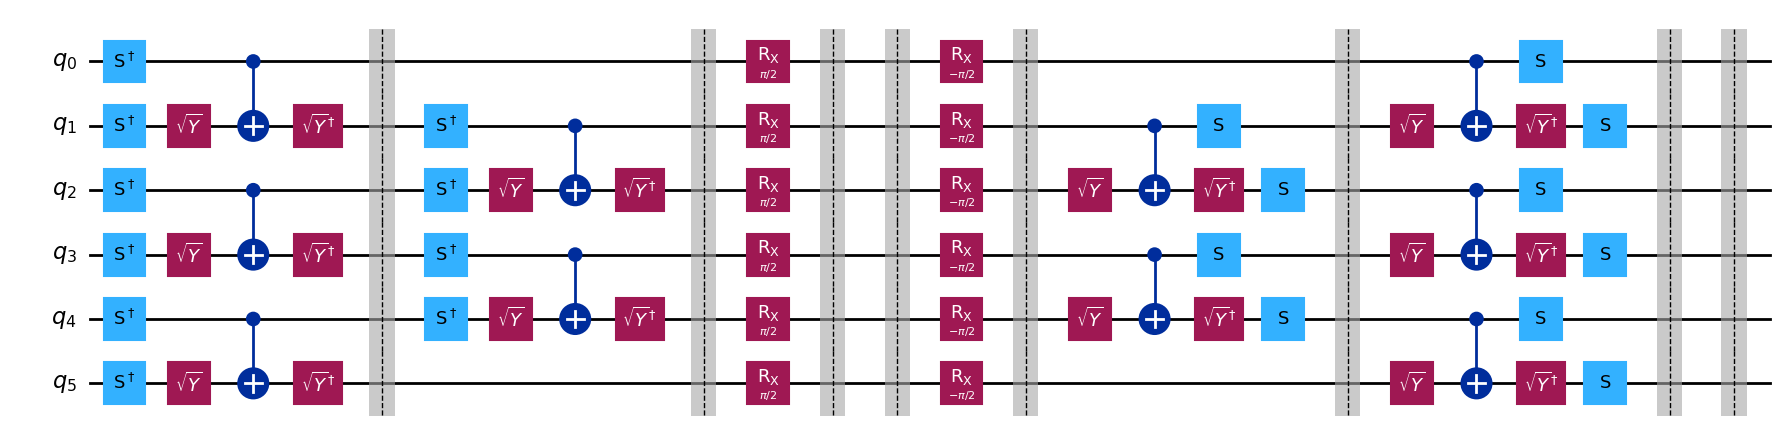

In [8]:
qc.draw(output = "mpl",fold = -1)

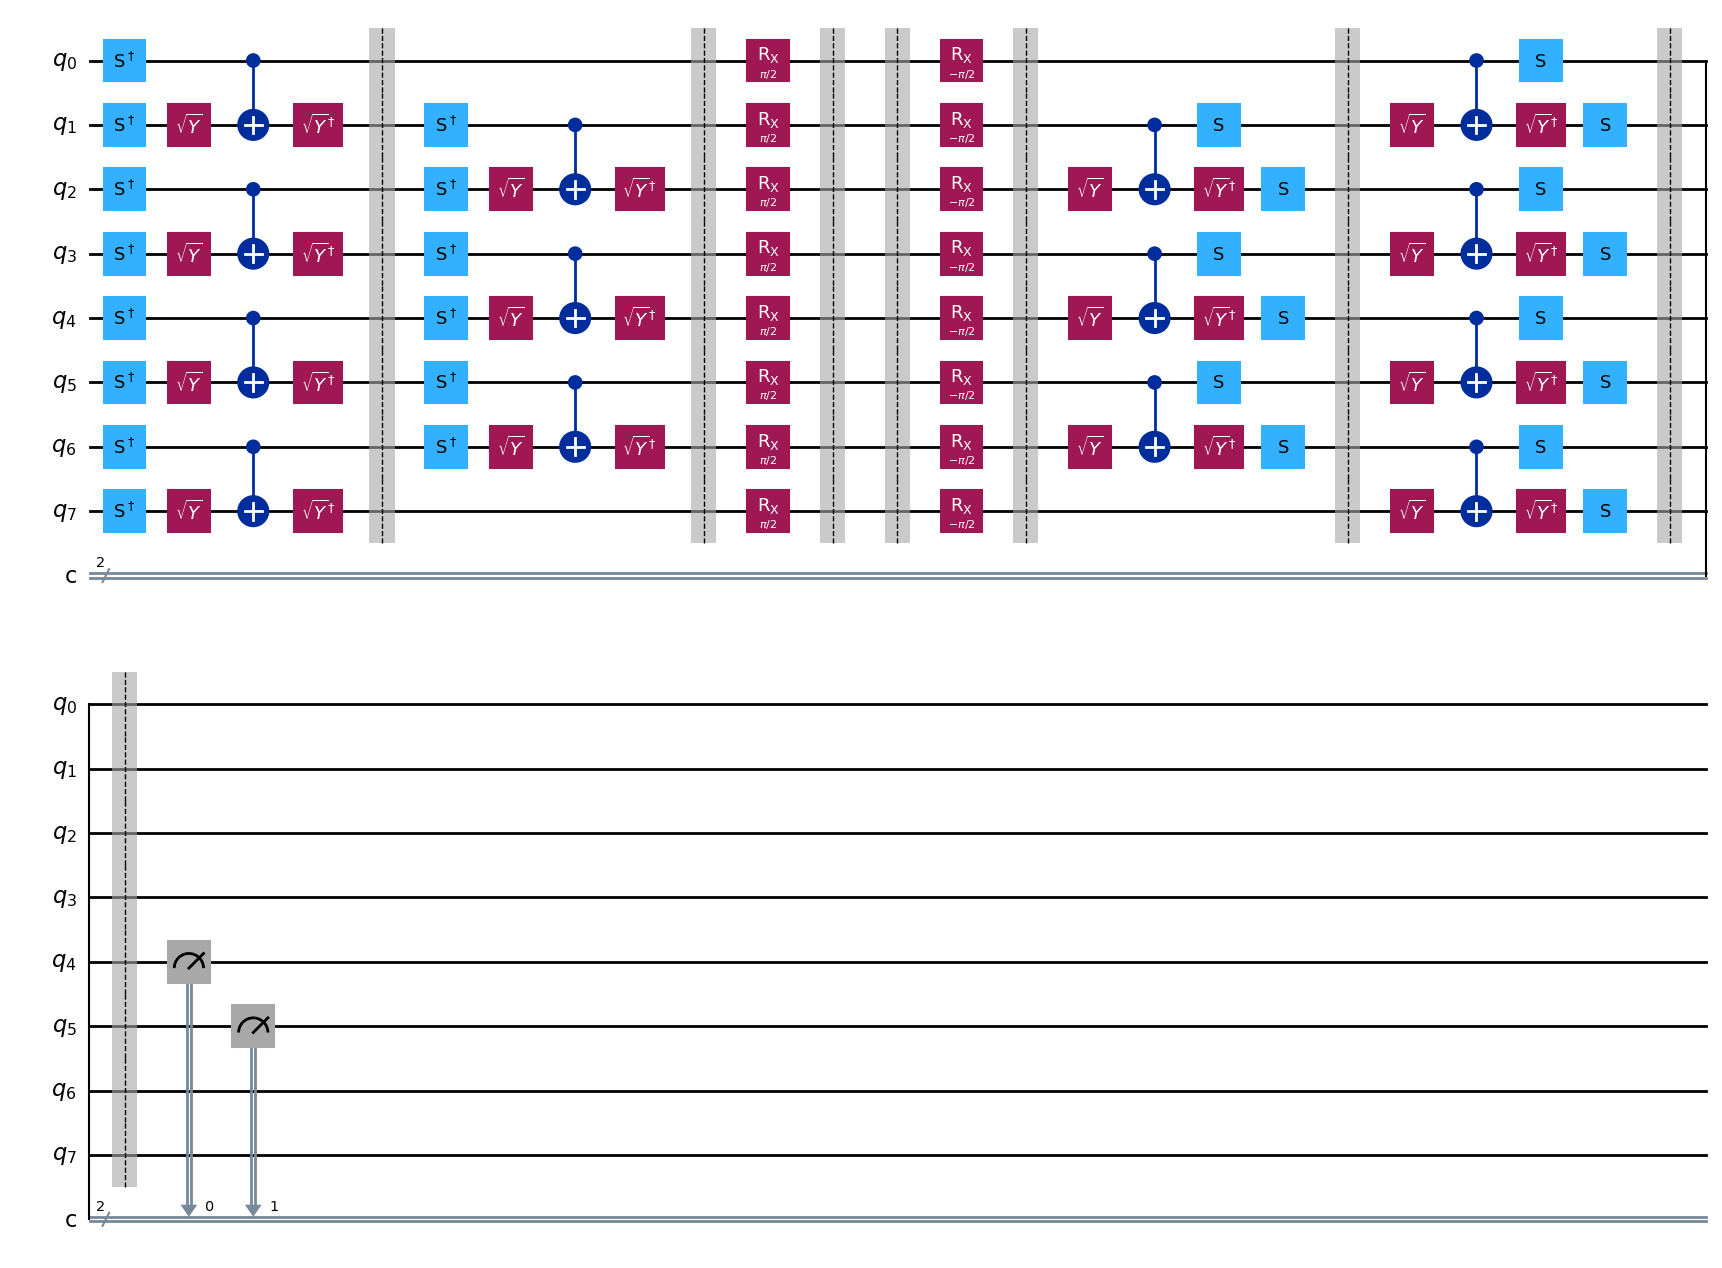

In [9]:
max_trotter_steps = 10
num_qubits = 8
measured_bits =[4,5]

qc_list = []
for trotter_steps in range(max_trotter_steps):
    qc = generate_1D_tfin_im(num_qubits,trotter_steps, rx_angle, num_cl_bits = len(measured_bits), trotter_barriers = True, layer_barriers = True)
    add_miirored_1D_tfin_im(qc, num_qubits,trotter_steps, rx_angle, trotter_barriers = True, layer_barriers = True)
    qc.measure(measured_bits,list(range(len(measured_bits))))
    qc_list.append(qc)

qc_list[1].draw(output = "mpl")
    
    
    

In [10]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
print('Done getting backend')


qc_transpiled_list = transpile(qc_list,backend = backend, optimization_level = 1)

AccountNotFoundError: 'Unable to find account.'

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = 'XY4'

job = sampler.run(qc_transpiled_list)
print(job.job_id())

cs14q3c75q40008tmb5g


In [ ]:
job_id = 'cs09sbdkfpw00080b96g'
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0'*len(measured_bits)]/data.c.num_shots)
    except:
        survival_probability_list.append(0)
    

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list(range(0,4*max_trotter_steps,4)),survival_probability_list,'--o')
plt.xlabel('2Q gate depth')
plt.ylabel('Survival probability of the all-0 bitstring')
plt.xticks(np.arange(0,44,4))
plt.show()

NameError: name 'survival_probability_list' is not defined

In [ ]:
from qiskit.circuit import Parameter
rx_angle = Parameter('rx_angle')
num_trotter_steps = 2
qc = generate_1D_tfin_im(num_qubits,num_trotter_steps, rx_angle)

from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits //2
observable = SparsePauliOp('I'*middle_index + 'Z' + 'I'*(middle_index-1))

In [ ]:
qc_transpiled = transpile(qc, backend=backend,optimization_level = 1)
observable =observable.apply_layout(qc_transpiled.layout)

In [ ]:
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2
num_rx_angle = 12

rx_angle_list = np.linspace(min_rx_angle,max_rx_angle,num_rx_angle)
options = EstimatorOptions()

options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = 'XY4'

estimator = EstimatorV2(backend = backend,options = options)
job = estimator.run([(qc_transpiled, observable, rx_angle_list)])

print(job.job_id())

cs14q4m75q40008tmb60


## Coding the fsim gates, we create a function to add such gates

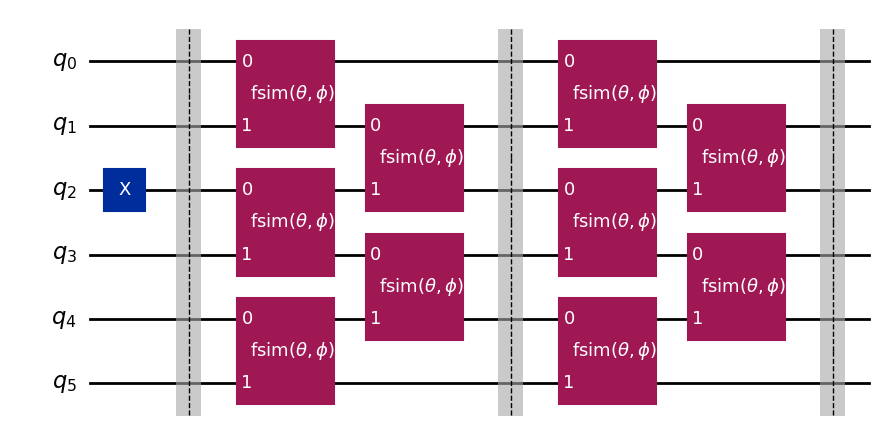

In [3]:
from qiskit.quantum_info import Operator
import math as m
import cmath as cm

def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def circuit(num_qubits, pos1, trotter_steps,angles = [0,0,0], num_cl_bits = 0, trotter_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    qc.x(pos1-1)
    qc.barrier()
    for trotter_step in range(trotter_steps):
        add_fsim(qc,angles)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_fsim(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')


num_qubits = 6
trotter_steps = 2
pos1 = 3
angles = [np.pi/4,0,0]
qc = circuit(num_qubits,pos1,trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl')
    

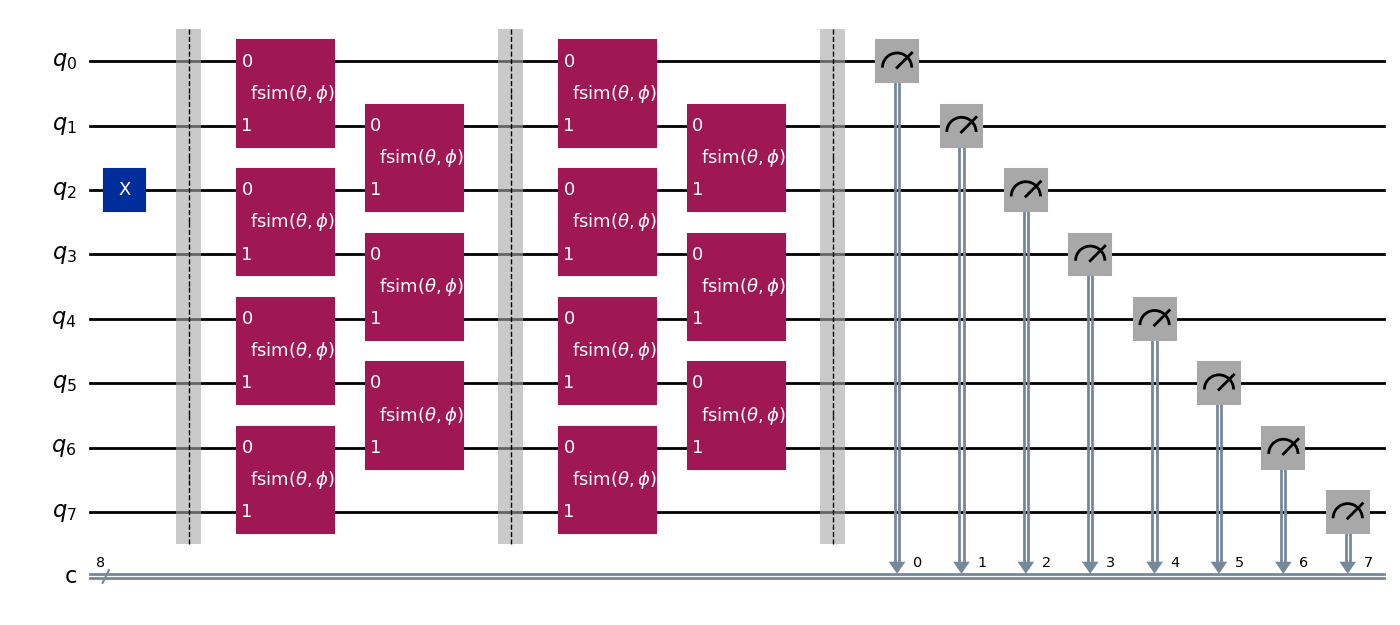

In [4]:
max_trotter_steps = 10
num_qubits = 8
measured_bits =[0,1,2,3,4,5,6,7]

qc_list = []
for trotter_steps in range(max_trotter_steps):
    qc = circuit(num_qubits,pos1, trotter_steps, angles, num_cl_bits = len(measured_bits), trotter_barriers = True)
    qc.measure(measured_bits,list(range(len(measured_bits))))
    qc_list.append(qc)

qc_list[2].draw(output = "mpl")

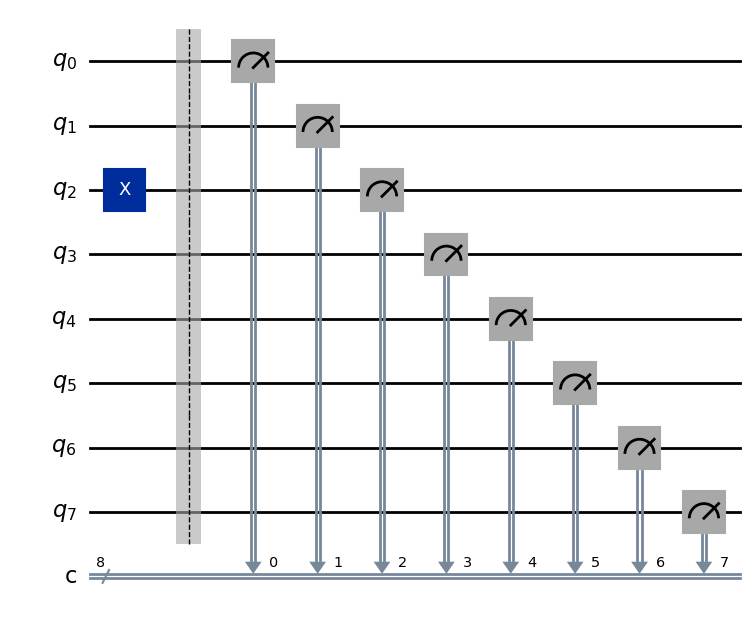

In [13]:
qc_list[0].draw(output = "mpl")

In [ ]:
qc_transpiled_list = transpile(qc_list,backend = backend, optimization_level = 1)

In [ ]:
#job = sampler.run(qc_transpiled_list)
#print(job.job_id())

cs14qadyhpyg008agn00


In [5]:
def required_bitsrings(num_qubits):
    bitstring_list = ['0'*i +'1' + '0'*(num_qubits-i-1) for i in range(num_qubits)]
    return bitstring_list

string_list = required_bitsrings(num_qubits)
for i in range(len(string_list)):
    string_list[i] = string_list[i][::-1]
print(string_list)


['00000001', '00000010', '00000100', '00001000', '00010000', '00100000', '01000000', '10000000']


[0.00146484375, 0.0009765625, 0.8212890625, 0.001220703125, 0, 0, 0.000732421875, 0.000244140625]
[0.004150390625, 0.00537109375, 0.002685546875, 0.022705078125, 0.6572265625, 0.00244140625, 0.000732421875, 0.00048828125]
[0.007080078125, 0.03271484375, 0.004150390625, 0.0078125, 0.003173828125, 0.001953125, 0.514892578125, 0.003662109375]
[0.02734375, 0.005615234375, 0.009765625, 0.005615234375, 0.005615234375, 0.004638671875, 0.00537109375, 0.40869140625]
[0.00341796875, 0.003662109375, 0.025390625, 0.005859375, 0.01123046875, 0.31103515625, 0.0107421875, 0.006591796875]
[0.0048828125, 0.004150390625, 0.0048828125, 0.28466796875, 0.01123046875, 0.00537109375, 0.0107421875, 0.005859375]
[0.002685546875, 0.23193359375, 0.005615234375, 0.00390625, 0.00732421875, 0.005859375, 0.009521484375, 0.00927734375]
[0.21728515625, 0.0078125, 0.010009765625, 0.003662109375, 0.007080078125, 0.0078125, 0.00537109375, 0.0087890625]
[0.010009765625, 0.00830078125, 0.147216796875, 0.009521484375, 0.011

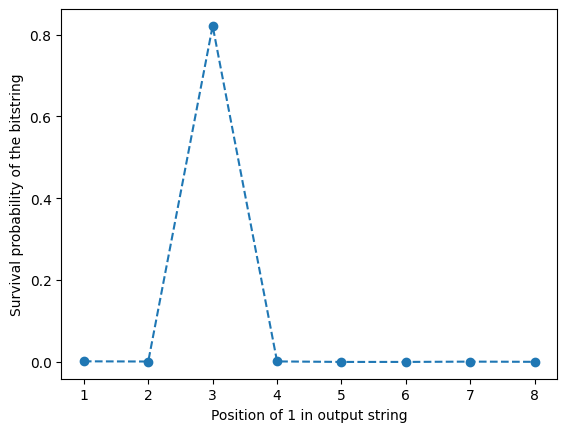

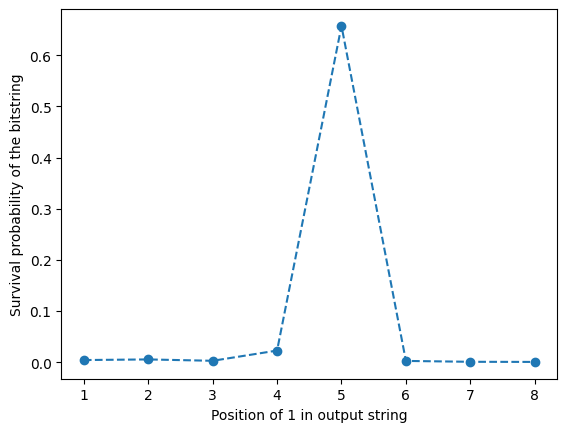

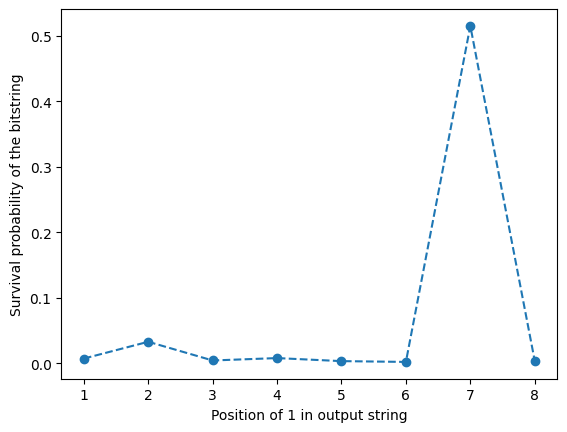

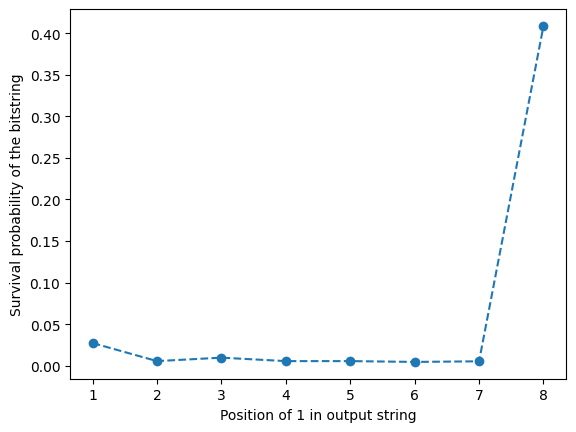

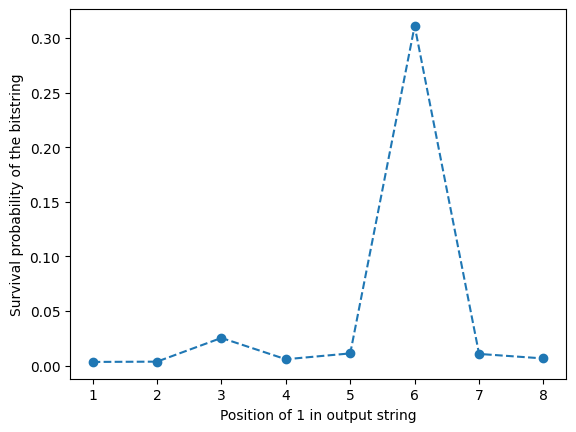

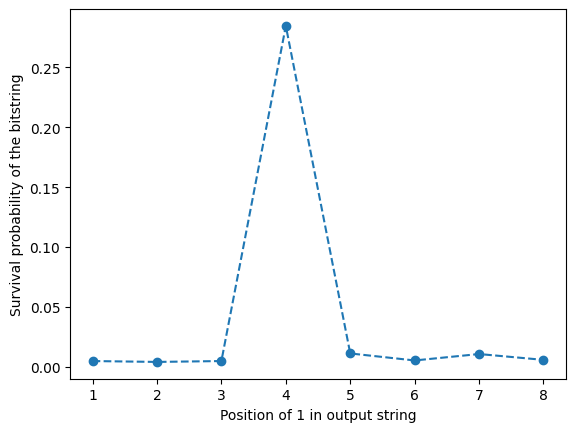

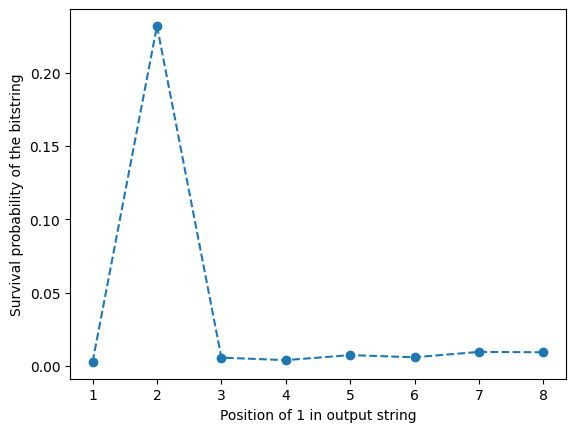

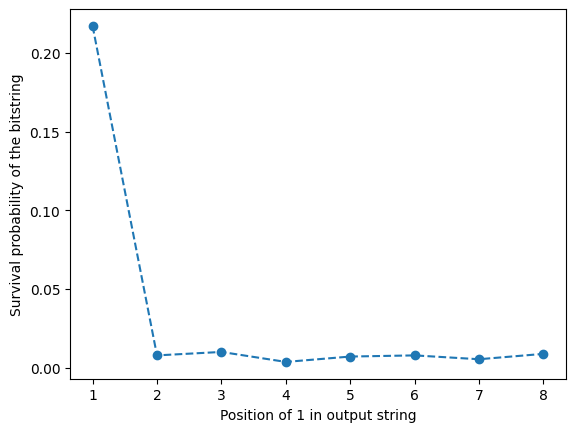

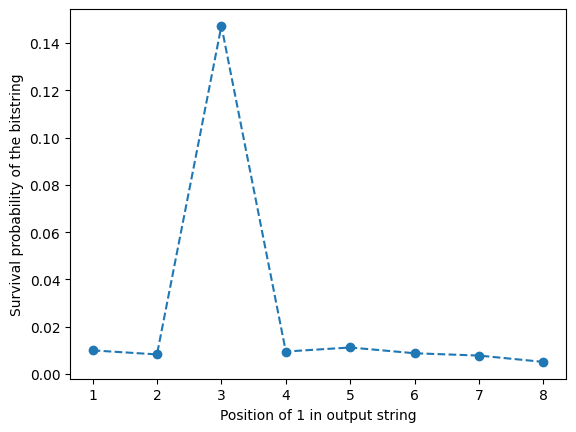

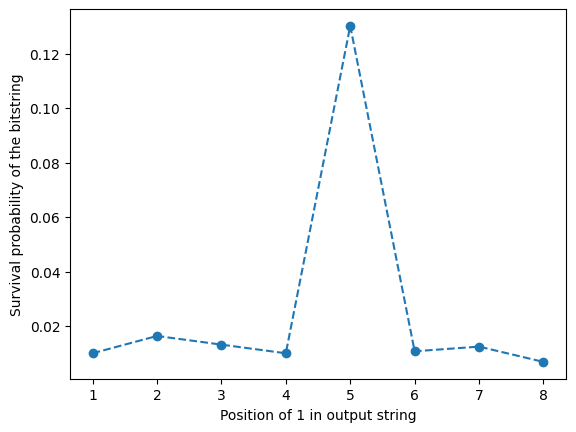

In [ ]:
job_id = 'cs0g0a1965y00084z3kg'
job = service.job(job_id)

string_distribution_list = []
for trotter_step in range(max_trotter_steps):
    data = job.result()[trotter_step].data
    list1 = []
    for i in string_list:
        try:
            list1.append(data.c.get_counts()[i]/data.c.num_shots)
        except:
            list1.append(0)
    print(list1)
    string_distribution_list.append(list1)

            
for trotter_step in range(max_trotter_steps):
    plt.plot(list(range(1,num_qubits+1)),string_distribution_list[trotter_step],'--o')
    plt.xlabel('Position of 1 in output string')
    plt.ylabel('Survival probability of the bitstring')
    plt.xticks(np.arange(1,9))
    plt.show()

[{4: 1.0}, {16: 0.25, 2: 0.25, 4: 0.25, 8: 0.25}, {1: 0.125, 16: 0.5625, 2: 0.0625, 32: 0.0625, 4: 0.0625, 64: 0.0625, 8: 0.0625}, {1: 0.182138347648319, 16: 0.0625, 2: 0.091069173824159, 32: 0.140625, 4: 0.039292478527522, 64: 0.390625, 8: 0.0625, 128: 0.03125}, {1: 0.0078125, 16: 0.082146239263761, 2: 0.114506673824159, 32: 0.0078125, 4: 0.152228760736239, 64: 0.287952065439602, 8: 0.026118326175841, 128: 0.321422934560398}, {1: 0.03125, 16: 0.005361652351682, 2: 0.00390625, 32: 0.007047033230885, 4: 0.239391684560398, 64: 0.01305916308792, 8: 0.091069173824159, 128: 0.608915042944956}, {1: 0.00652958154396, 16: 0.160711467280199, 2: 0.04553458691208, 32: 0.135953283230886, 4: 0.00067020654396, 64: 0.276558554192279, 8: 0.152228760736239, 128: 0.221813559560398}, {1: 0.0087890625, 16: 0.039292478527522, 2: 0.003712417177896, 32: 0.780100530483374, 4: 0.126112900690224, 64: 0.012910917369552, 8: 0.027573728527522, 128: 0.00150796472391}, {1: 0.000538589052896, 16: 0.191003999137329, 2

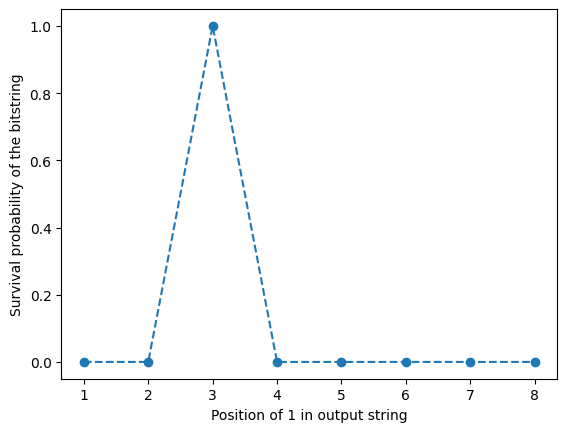

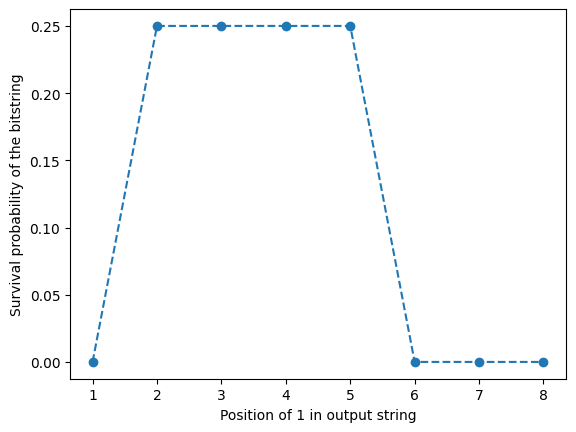

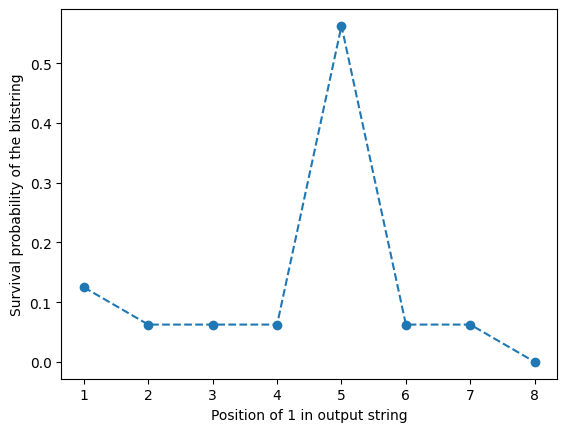

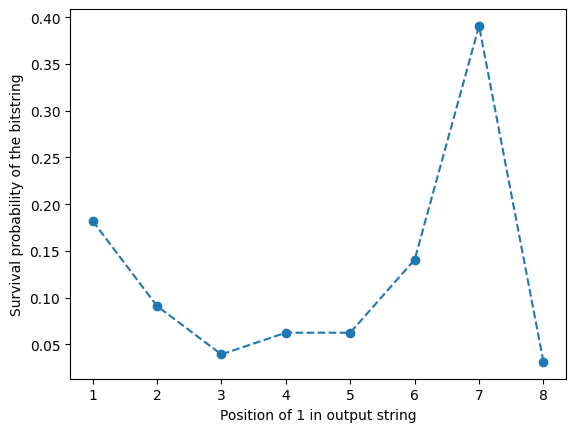

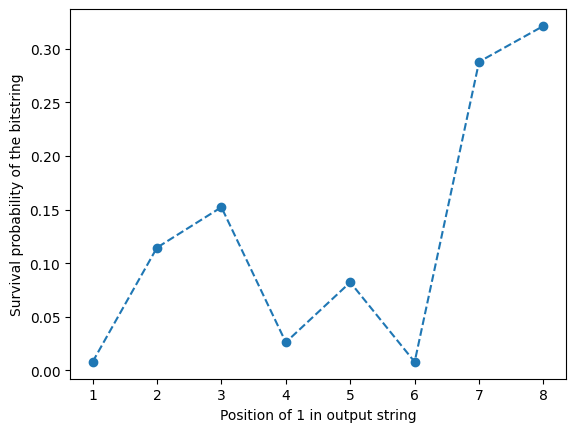

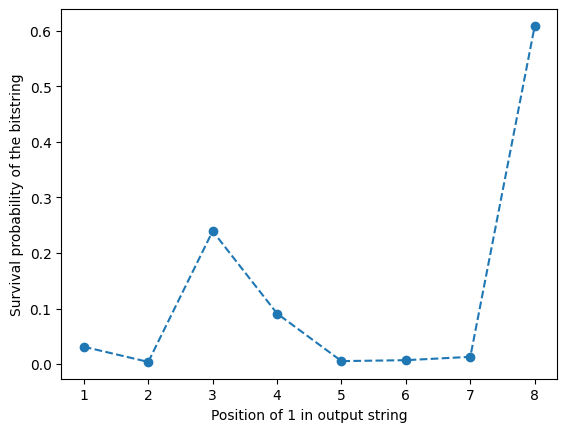

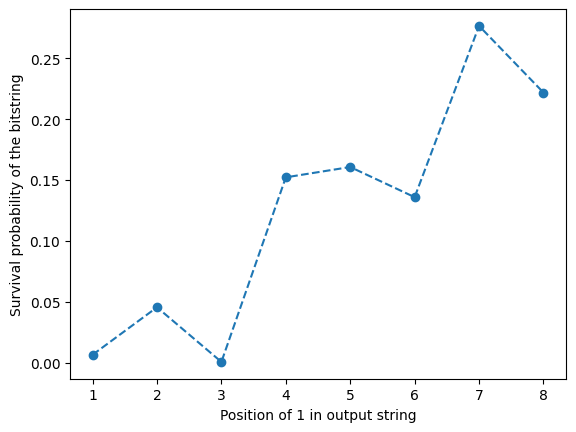

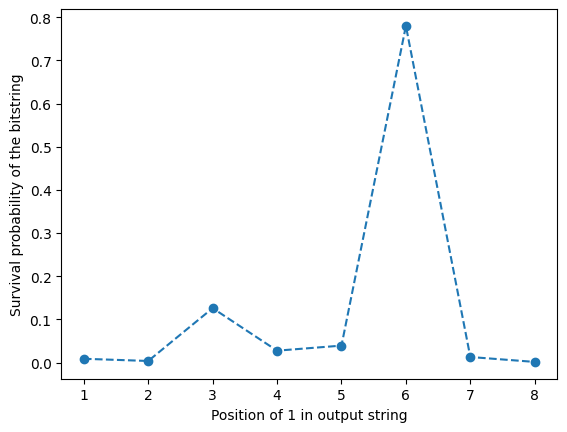

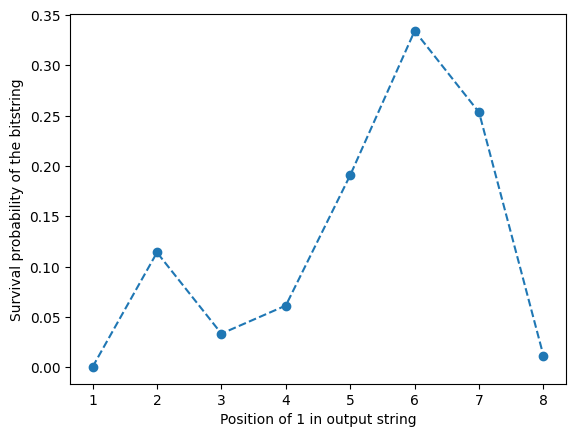

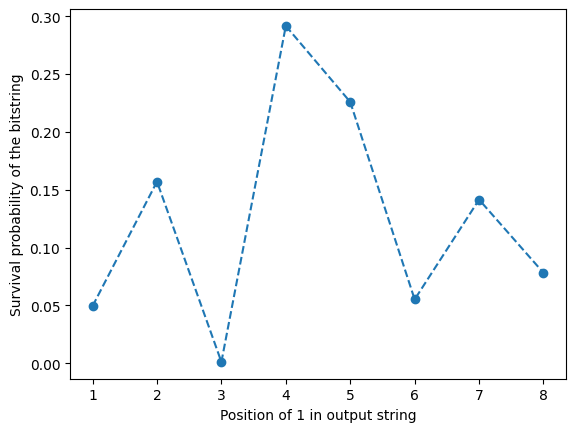

In [6]:
from qiskit_aer.primitives import Sampler
import matplotlib.pyplot as plt

sampler = Sampler()
job = sampler.run(qc_list,shots = None)
exact_quasis = job.result().quasi_dists
print(exact_quasis)

sim_distribution_list = []
for trotter_step in range(max_trotter_steps):
    data = job.result().quasi_dists[trotter_step]
    list1 = []
    for i in string_list:
        num = int(i,2)
        try:
            list1.append(data[num])
        except:
            list1.append(0)
        
    print(list1)
    sim_distribution_list.append(list1)


for trotter_step in range(max_trotter_steps):
    plt.plot(list(range(1,num_qubits+1)),sim_distribution_list[trotter_step],'--o')
    plt.xlabel('Position of 1 in output string')
    plt.ylabel('Survival probability of the bitstring')
    plt.xticks(np.arange(1,9))
    plt.show()

## Calculating the band structure for a ring arrangement

In [7]:
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp

def circuit_ring(num_qubits, pos1, trotter_steps,angles = [0,0,0], num_cl_bits = 0, trotter_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    qc.h(pos1-1)
    qc.barrier()
    for trotter_step in range(trotter_steps):
        add_fsim_ring(qc,angles)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_fsim_ring(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi,\beta)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi,\beta)$')

    #Adding fsim between first and last qubit
    qc.unitary(fsim1,[qc.num_qubits-1,0],label = r'fsim$(\theta,\phi,\beta)$')

def estimate(qc_list,num_qubits):
    x_observables = [SparsePauliOp('I'*i + 'X' + 'I'*(num_qubits-1-i)) for i in range(num_qubits)]
    y_observables = [SparsePauliOp('I'*i + 'Y' + 'I'*(num_qubits-1-i)) for i in range(num_qubits)]
    #plus_obervables = x_observables + 1j*y_observables
    #plus_obervables= [observable.apply_layout(qc_transpiled_list.layout) for observable in plus_observables]

    estimator =  Estimator(approximation=True)
    job_x = estimator.run(qc_list,x_observables,shots = None)
    job_y = estimator.run(qc_list,y_observables,shots = None)
    expectation_list_x = list(job_x.result().values)
    expectation_list_y = list(job_y.result().values)

    expectation_list = [expectation_list_x[i] + 1j*expectation_list_y[i] for i in range(len(expectation_list_x))]

    return expectation_list

    
    


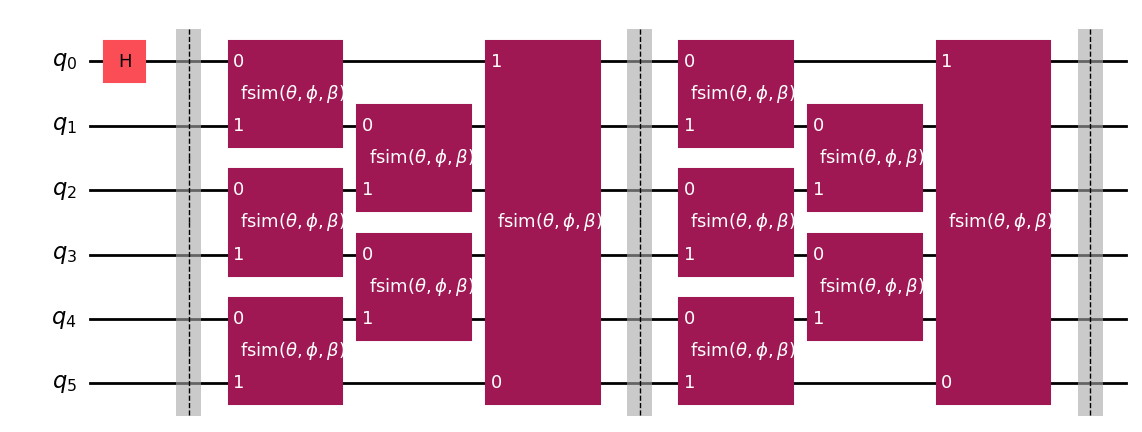

In [8]:
num_qubits = 6
num_trotter_steps = 20
angles = [np.pi/6,0,0]

pos1 = 1
trotter_steps = 2

qc = circuit_ring(num_qubits, pos1, trotter_steps,angles = angles, num_cl_bits = 0, trotter_barriers = True)
qc.draw(output='mpl')




In [9]:
evs_array = []
for trotter_step in range(num_trotter_steps):
    qc_list = []
    for pos in range(num_qubits):
        qc = circuit_ring(num_qubits, pos1, trotter_step,angles = angles)
        qc_list.append(qc)
    evs_array.append(estimate(qc_list,num_qubits))

evs_array_real = []
evs_array_imag = []
for i in evs_array:
    real_arr = [i[k].real for k in range(len(i))]
    imag_arr = [i[k].imag for k in range(len(i))]
    evs_array_real.append(real_arr)
    evs_array_imag.append(imag_arr)

print(evs_array_imag)
print(evs_array_real)
        
    


[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.4330127018922193, 0.0, 0.0, 0.0, 0.4330127018922193, 0.0], [0.5412658773652742, 0.0, -0.21650635094610962, 0.0, 0.5412658773652742, 0.0], [0.29769623255090094, 0.0, -0.5953924651018014, 0.0, 0.29769623255090094, 0.0], [-0.02029747040119759, 0.0, -0.8254304629820433, 0.0, -0.020297470401197656, 0.0], [-0.11671045480688724, 0.0, -0.6326044941706648, 0.0, -0.1167104548068873, 0.0], [0.032560525435254666, 0.0, -0.06512105087051025, 0.0, 0.03256052543525461, 0.0], [0.17369137431858317, 0.0, 0.5186426551472721, 0.0, 0.1736913743185831, 0.0], [0.054893028676156294, 0.0, 0.7562393464321271, 0.0, 0.054893028676156336, 0.0], [-0.2941349250814195, 0.0, 0.5882698501628404, 0.0, -0.2941349250814194, 0.0], [-0.5696291475686408, 0.0, 0.27323289135284323, 0.0, -0.5696291475686408, 0.0], [-0.4862097322175924, 0.0, 0.10639406065074475, 0.0, -0.4862097322175925, 0.0], [-0.06473153286603597, 0.0, 0.12946306573207003, 0.0, -0.06473153286603614, 0.0], [0.37292954970202996

In [36]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(channel = "ibm_quantum", #ibm_cloud
                               token = '60cc76a21936e2369c78f5c20e3aeafa53ce9611689830e893ca4ae55a556e12257888b95e65997248c6c64f75e79af7d183ce999c2d0e9077625aa5c03817a4')
#service.save_account(channel = "ibm_quantum", #ibm_cloud
                              #token = '60cc76a21936e2369c78f5c20e3aeafa53ce9611689830e893ca4ae55a556e12257888b95e65997248c6c64f75e79af7d183ce999c2d0e9077625aa5c03817a4')
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=num_qubits)

print(backend.name)

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)




    
    

IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [128]:
def estimate2(qc_list,num_qubits):
    x_observables = [SparsePauliOp('I'*i + 'X' + 'I'*(num_qubits-1-i)) for i in range(num_qubits)]
    y_observables = [SparsePauliOp('I'*i + 'Y' + 'I'*(num_qubits-1-i)) for i in range(num_qubits)]

    pubs_x = []
    pubs_y = []

    for qc, obs in zip(qc_list, x_observables):
        isa_circuit = pm.run(qc)
        isa_obs = obs.apply_layout(isa_circuit.layout)
        pubs_x.append((isa_circuit, isa_obs))

    for qc, obs in zip(qc_list, y_observables):
        isa_circuit = pm.run(qc)
        isa_obs = obs.apply_layout(isa_circuit.layout)
        pubs_y.append((isa_circuit, isa_obs))

    estimator = Estimator2(backend)
    job_x = estimator.run(pubs_x)
    job_y = estimator.run(pubs_y)

    job_x_results = job_x.result()
    job_y_results = job_y.result()

    expectation_list = [job_x_results[i].data.evs + 1j*job_y_results[i].data.evs for i in range(num_qubits)]

    return expectation_list

evs_array2 = []
for trotter_step in range(num_trotter_steps):
    qc_list = []
    for pos in range(num_qubits):
        qc = circuit_ring(num_qubits, pos, trotter_step,angles = angles)
        qc_list.append(qc)
    evs_array2.append(estimate2(qc_list,num_qubits))

evs_array_real2 = []
evs_array_imag2 = []
for i in evs_array2:
    real_arr2 = [i[k].real for k in range(len(i))]
    imag_arr2 = [i[k].imag for k in range(len(i))]
    evs_array_real2.append(real_arr2)
    evs_array_imag2.append(imag_arr2)

print(evs_array_imag2)

NameError: name 'pm' is not defined

## Code to do Fourier transform

In [10]:
#Let us just see what happends if we use scipy's 2D FFT firstly

import scipy.fft as fft

fft_2d = fft.fft2(evs_array)
print(fft_2d)

[[ 1.50000000e+00 +0.8660254j  -1.62080726e+00 +0.55092254j
   1.62080726e+00 +0.55092254j -1.50000000e+00 +0.8660254j
  -4.19584036e+00 +2.80732053j  4.19584036e+00 +2.80732053j]
 [ 1.87803665e+00 +1.5208041j  -6.28208288e+00 +1.67297187j
  -5.40173977e-01 -0.94261265j -1.28472615e+00 +0.49316017j
  -4.10925590e+00 +1.67997575j  8.63958119e+00 +8.2653022j ]
 [ 2.78716460e+00 +3.09545988j  1.14810743e+01 -1.48097662j
   3.47676015e+00 +4.25370636j -1.13988639e+00 +0.24229033j
   6.36678612e-01 +0.28724225j -1.05694409e+01-14.15112103j]
 [ 9.01237455e+00+13.87783981j  3.53221125e+00 +0.05852179j
   1.19748271e+00 +1.87183878j -1.03120174e+00 +0.05404299j
  -9.07391332e-01 +0.26078389j -2.23336584e+00 -4.30465235j]
 [-3.36984066e+00 -7.56878604j  2.16169681e+00 +0.3624343j
   6.59835743e-01 +1.44418145j -9.42789676e-01 -0.09909119j
  -9.99534569e-01 +0.06112189j -8.74106450e-01 -2.66242156j]
 [-8.66025404e-01 -3.23205081j  1.55890378e+00 +0.51293293j
   3.60092254e-01 +1.24865667j -8.660

In [11]:
fft_2d_abs = np.abs(fft_2d)**2
print(fft_2d_abs)

[[  3.           2.93053183   2.93053183   3.          25.48612484
   25.48612484]
 [  5.83986678  42.26340018   1.18030653   1.89372824  19.70830257
  142.95758352]
 [ 17.35015835 134.0083588   30.18187894   1.35804558   0.48786776
  311.96730735]
 [273.81733297  12.47994112   4.93774526   1.06629767   0.89136727
   23.51795484]
 [ 68.64234823   4.80429173   2.52104326   0.89867144   1.00280524
    7.85255067]
 [ 11.19615242   2.6932812    1.68880991   0.80384758   0.94170166
    3.95511553]
 [  4.53351089   1.81714994   1.29542201   0.75828518   0.87999736
    2.44518116]
 [  2.52838808   1.37760267   1.08683231   0.75205993   0.84546469
    1.71777577]
 [  1.67509512   1.13671811   0.97732139   0.78388522   0.84307791
    1.32126807]
 [  1.24181264   1.00411713   0.932847     0.8605137    0.87635014
    1.09016054]
 [  1.           0.94129748   0.94129748   1.           0.9531463
    0.9531463 ]
 [  0.8605137    0.932847     1.00411713   1.24181264   1.09016054
    0.87635014]
 [  0

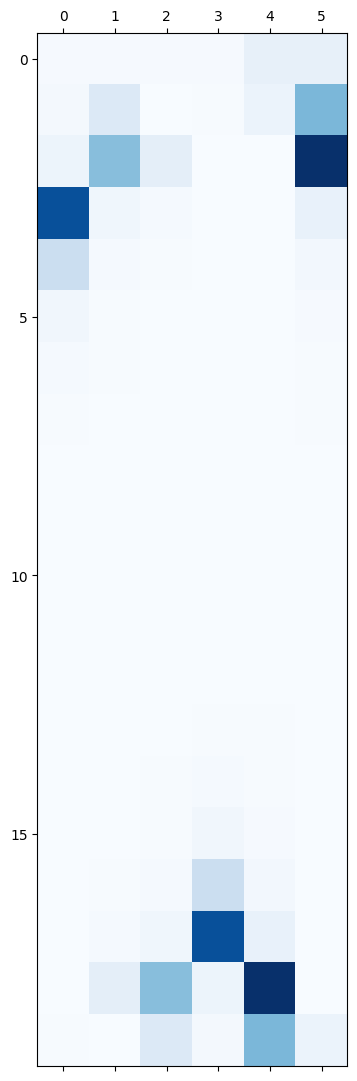

In [12]:
plt.matshow(fft_2d_abs, cmap=plt.cm.Blues)

In [13]:
#Making our own discrete fourier tansform function

def dft_2d(evs_array,n_k = num_qubits, n_w = num_trotter_steps):
    t = evs_array.shape[0]
    j = evs_array.shape[1]

    dft_arr = np.zeros((n_w,n_k),dtype=complex)
    w_arr = np.linspace(-np.pi,np.pi,n_w)  #can be updated for more points on the dft graph
    k_arr = np.linspace(-np.pi,np.pi,n_k)
    for i in range(n_w):
        for l in range(n_k):
            dft_arr[i,l] = exp_sum(evs_array,w_arr[i],k_arr[l])
            #print(dft_arr[i,l])
    dft_arr = 2*m.sqrt(num_qubits)*dft_arr/(n_k*n_w)

    return dft_arr

def exp_sum(evs_array,w,k):
    t = evs_array.shape[0]
    j = evs_array.shape[1]
    sum = 0 + 0j
    for n in range(t):
        for m in range(j):
            sum += evs_array[n,m]*cm.exp(-1j*(w*n - k*m))

    #sum_real = sum.real
    #sum_imag = sum.imag
    return sum

In [14]:
evs_array = np.array(evs_array)
print(evs_array)

[[ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          1.        +0.j        ]
 [ 0.        +0.4330127j   0.        +0.j          0.        +0.j
  -0.25      +0.j          0.        +0.4330127j   0.75      +0.j        ]
 [ 0.        +0.54126588j -0.125     +0.j          0.        -0.21650635j
  -0.5625    +0.j          0.        +0.54126588j  0.1875    +0.j        ]
 [ 0.        +0.29769623j -0.09375   +0.j          0.        -0.59539247j
  -0.609375  +0.j          0.        +0.29769623j -0.296875  +0.j        ]
 [ 0.        -0.02029747j  0.2109375 +0.j          0.        -0.82543046j
  -0.25390625+0.j          0.        -0.02029747j -0.45703125+0.j        ]
 [ 0.        -0.11671045j  0.58789062+0.j          0.        -0.63260449j
   0.29003906+0.j          0.        -0.11671045j -0.37792969+0.j        ]
 [ 0.        +0.03256053j  0.69287109+0.j          0.        -0.06512105j
   0.63647461+0.j          0.        +0.03256053

In [100]:
import matplotlib.pyplot as plt

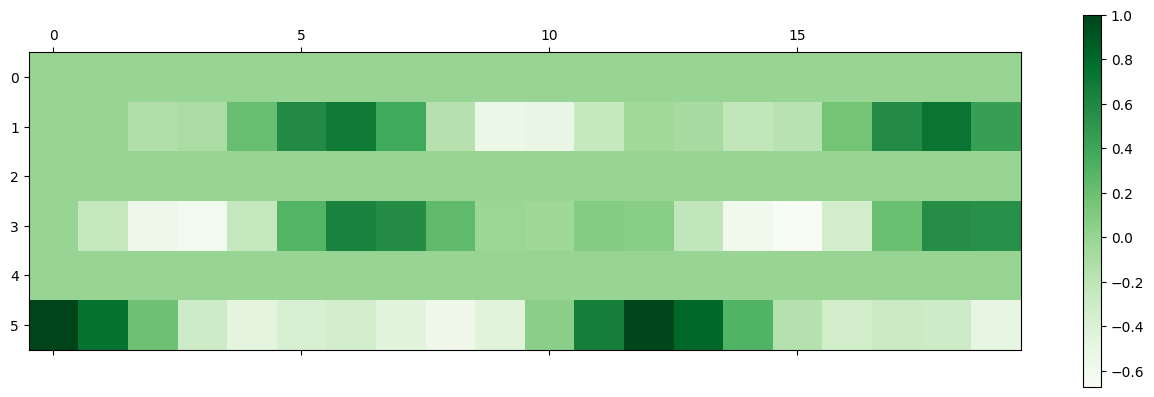

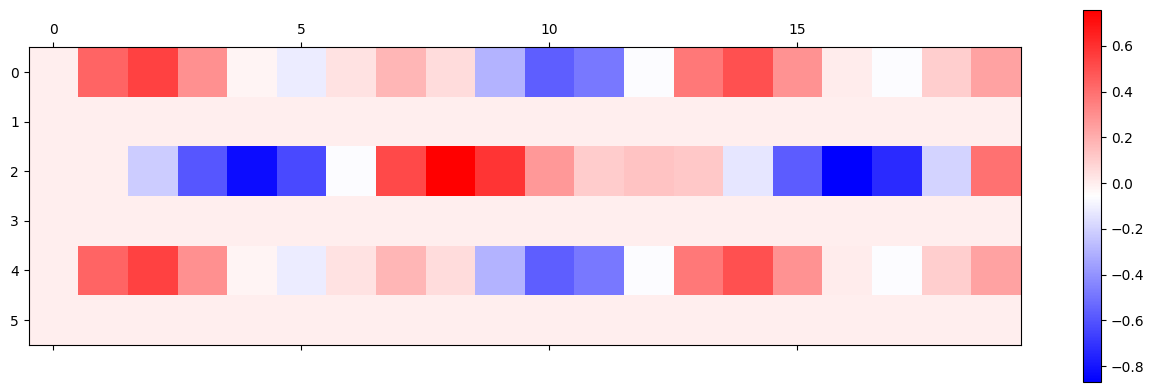

In [15]:
import matplotlib.pyplot as plt

evs_array_real = np.array(evs_array_real).T
evs_array_imag = np.array(evs_array_imag).T
plt.matshow(evs_array_real, cmap=plt.cm.Greens)
plt.colorbar()
plt.matshow(evs_array_imag, cmap=plt.cm.bwr)
plt.colorbar()

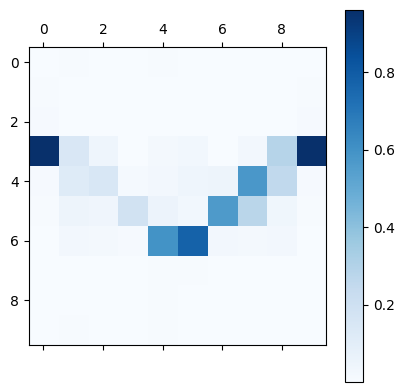

In [16]:
dft_array = dft_2d(evs_array,n_k=10,n_w=10)
dft_array = np.abs(dft_array)**2
plt.matshow(dft_array, cmap=plt.cm.Blues)
plt.colorbar()


In [ ]:
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
# Bell Circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
 
# Run the sampler job locally using AerSimulator.
# Session syntax is supported but ignored because local mode doesn't support sessions.
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
with Session(backend=aer_sim) as session:
    sampler = Sampler(session=session)
    result = sampler.run([isa_qc]).result()

/home/sarma/miniconda3/envs/qiskitenv/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


In [ ]:
print(result)

PrimitiveResult([PubResult(data=DataBin<>(meas=BitArray(<shape=(), num_shots=1024, num_bits=2>)))], metadata={})


In [17]:
## Let us plot the analytical dispersion relation now

def dispersion(k,theta):
    c_eff = m.cos(theta)**2 - m.cos(k)*m.sin(theta)**2
    s_eff = np.sqrt(1 - c_eff**2)
    if s_eff == 0:
         s_eff = 0.001
    theta_eff = m.acos(c_eff)
    val = m.cos(theta)**2 + (m.sin(k/2)**2)*m.sin(theta)**2
    return (theta_eff/s_eff)*(2*abs(m.cos(k/2))*m.sin(theta)*np.sqrt(val))

def disp_plot(k_arr,theta):
    w_arr = []
    for k in k_arr:
        w_arr.append(dispersion(k,theta))
    return w_arr

Text(0, 0.5, 'w')

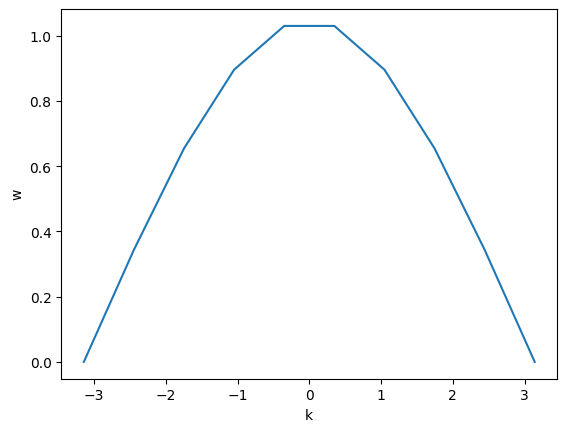

In [18]:
theta_check = np.pi/6
k_arr = np.linspace(-np.pi,np.pi,10)

w_arr = disp_plot(k_arr,theta_check)
plt.plot(k_arr,w_arr,label = "Dispersion relation")
plt.xlabel("k")
plt.ylabel("w")

In [74]:
a = [0,1,2,3]
b = [1,2,3,4]
print(zip(a,b))

[7, 4, 2, 0, 0, 0, 0, 2, 4, 7]
[[0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


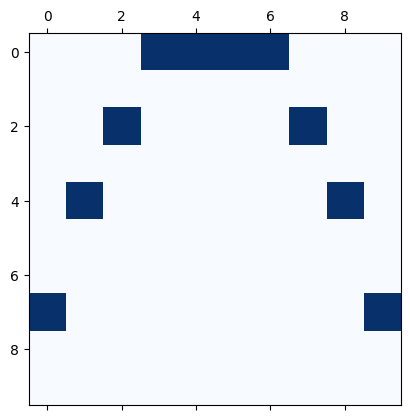

In [79]:
## Let's try to do a mathsow of the above plot

def check_closest(w,val_list,k_arr):
    dis = 10000  #some high value
    ind = 0
    for i in range(len(k_arr)):
        if abs(w-k_arr[i])<dis:
            ind = val_list[i]
            dis = abs(w-k_arr[i])
    return ind


val_list = list(range(len(k_arr)))
k_diff_arr = np.linspace(-0.8,0.2,10)
#check_list = zip(,k_arr)
ind_list =[]
for w in w_arr:
    ind_list.append(check_closest(w,val_list,k_diff_arr))

print(ind_list)

disp_mat = np.zeros((len(k_arr),len(k_arr)))
for i,j in zip(list(range(len(k_arr))),ind_list):
    disp_mat[j,i] = 1

plt.matshow(disp_mat, cmap=plt.cm.Blues)

print(disp_mat)
    


[1, (-0.1338201630174893+0.15067240557766887j), (-0.19055578621298425-0.00034834702099512766j), (0.13170866146169868+0.06457972080261187j), (0.5998803349340743-0.46579090812471136j), (0.4400952653610535+0.7723983808527287j), (-0.005904254259784151-0.1913323500084097j), (0.33574173498999804-0.1344680061005549j), (-0.06172485091192968+0.17424833403523185j), 1]
[1, 0.04061000983258895, 0.036311629004895596, 0.021517711842975656, 0.5768175863322603, 0.7902831013371331, 0.03664292837810477, 0.13080415727875294, 0.03417243913415369, 1]


C:\Users\DELL\AppData\Local\Temp\ipykernel_54652\2162833315.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  dft_mat[i,l] = exp_sum(evs_array,w_arr[i],k_arr[l])


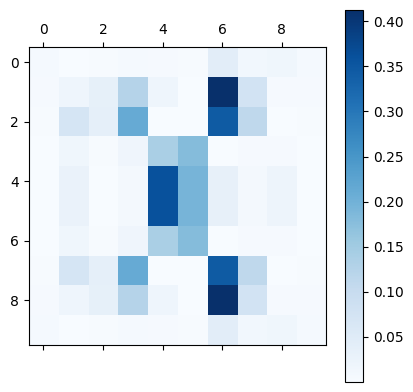

In [19]:
## Let us just pass the w_arr to the dft 2d function to see what happens

def dft_2d_2(w_arr,k_arr,evs_array):
    #t = evs_array.shape[0]
    #j = evs_array.shape[1]

    #dft_arr = np.zeros((n_w,n_k),dtype=complex)
    #w_arr = np.linspace(-np.pi,np.pi,n_w)  #can be updated for more points on the dft graph
    #k_arr = np.linspace(-np.pi,np.pi,n_k)

    amp_arr = []
    for i in range(len(k_arr)):
            amp_arr.append(exp_sum(evs_array,w_arr[i],k_arr[i]))
            #print(exp_sum(evs_array,w_arr[i],k_arr[i]))
    amp_arr = [2*m.sqrt(num_qubits)*k/(len(k_arr)*len(w_arr)) for k in amp_arr]

    return amp_arr

amp_arr = dft_2d_2(w_arr,k_arr,evs_array)
for i in range(len(amp_arr)):
    if i == 0 or i == len(amp_arr)-1:
        amp_arr[i] = 1
print(amp_arr)

amp_square_arr = [np.abs(k)**2 for k in amp_arr]
print(amp_square_arr)


## Let us try to plot the above array

def dft_matshow_2(w_arr,k_arr,evs_array):
    dft_mat = np.zeros((len(k_arr),len(k_arr)))
    n_k = len(k_arr)
    n_w = len(w_arr)
    for i in range(n_w):
        for l in range(n_k):
            dft_mat[i,l] = exp_sum(evs_array,w_arr[i],k_arr[l])
            #print(dft_arr[i,l])
    dft_mat = 2*m.sqrt(num_qubits)*dft_mat/(n_k*n_w)

    dft_mat = np.abs(dft_mat)**2
    plt.matshow(dft_mat, cmap=plt.cm.Blues)
    plt.colorbar()


dft_matshow_2(w_arr,k_arr,evs_array)




In [55]:
print(dft_array)
print()
print(dft_array[0,:])
print()
print(dft_array[:,0])

[[2.40000000e-03 2.84521718e-03 1.59446262e-03 2.25911395e-03
  2.95896318e-03 1.15652864e-03 2.28755112e-03 4.73513313e-03
  6.03025387e-04 2.40000000e-03]
 [5.63351125e-03 2.52361956e-03 7.06767566e-04 1.72973658e-03
  1.05883049e-03 2.83597670e-05 2.39495389e-03 2.87629317e-03
  1.03375102e-03 5.63351125e-03]
 [8.47701333e-03 8.97191546e-04 1.91952190e-04 2.42815635e-04
  2.81561046e-05 1.09903051e-03 1.13583873e-03 1.01513119e-03
  2.80020253e-03 8.47701333e-03]
 [9.60000000e-01 1.17822503e-01 9.50586245e-02 2.26228292e-03
  1.03528180e-02 3.45933380e-02 9.11073662e-05 7.14655755e-02
  2.10652944e-01 9.60000000e-01]
 [8.47701333e-03 1.04780744e-01 2.24632745e-01 1.19074429e-02
  5.16661424e-02 5.79376286e-02 4.54096493e-02 3.26723293e-01
  3.95870293e-01 8.47701333e-03]
 [5.63351125e-03 4.02171471e-02 1.15793698e-01 1.84288758e-01
  6.04794634e-02 9.21459589e-02 5.62553593e-01 3.91326910e-02
  1.27160131e-01 5.63351125e-03]
 [2.40000000e-03 1.24898525e-02 6.33545136e-02 1.08687867e

In [20]:
print(w_arr)

def max_ind(arr):
    max_val = max(arr)
    for i in range(len(arr)):
        if arr[i] == max_val:
            return i
        
def avg_arr(arr,k_arr):
    val = 0
    sum = 0
    for i in range(len(arr)):
        sum+=arr[i]
    for i in range(len(arr)):
        val += arr[i]*k_arr[i] #weighted sum

    return val/sum

w_num_arr = []
for j in range(len(k_arr)):
    ind = max_ind(dft_array[:,j])
    w_num_arr.append(ind)

w_final_arr2 = []
for j in range(len(k_arr)):
    w_final_arr2.append(avg_arr(dft_array[:,j],k_arr))
    

print(w_num_arr)
print(dft_array[2,:])
    

[0.0, 0.34370950263747857, 0.6544020313662703, 0.8956647938578646, 1.029699027809482, 1.029699027809482, 0.895664793857865, 0.6544020313662703, 0.34370950263747857, 0.0]
[3, 3, 4, 5, 6, 6, 5, 4, 3, 3]
[8.47701333e-03 1.48661420e-03 7.17606637e-04 2.42815635e-04
 2.96478378e-05 1.30615781e-03 1.13583873e-03 6.09198204e-05
 2.43071776e-03 8.47701333e-03]


In [21]:
print(k_arr)
print(w_final_arr2)

[-3.14159265 -2.44346095 -1.74532925 -1.04719755 -0.34906585  0.34906585
  1.04719755  1.74532925  2.44346095  3.14159265]
[-1.03527794858751, -0.44456874990922246, -0.23750261095183925, 0.3107917897497707, 0.8995920826579448, 0.892394546391357, 0.3145459114612772, -0.11794223189767468, -0.5674623707345435, -1.0352779485875099]


In [22]:
w_final_arr2_plot = [i/np.pi for i in w_final_arr2]

In [23]:
w_final_arr3 = [(i+1)/(2*np.pi) for i in w_final_arr2]

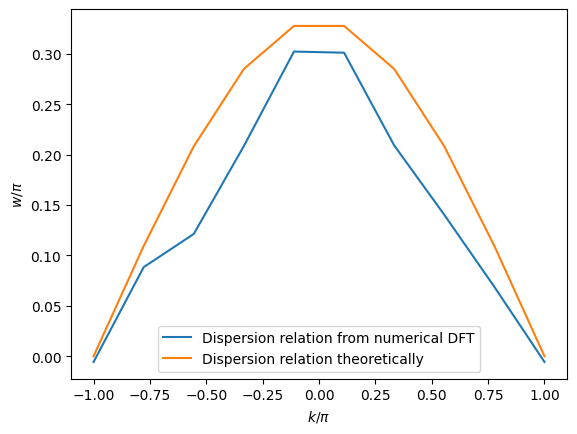

In [25]:
w_final_arr  = [(k_arr[i] +1)/(2*np.pi) for i in w_num_arr]
k_arr_plot = [k/np.pi for k in k_arr]

w_arr_plot = [w/np.pi for w in w_arr]
  #scaling the graph properly

plt.plot(k_arr_plot,w_final_arr3,label = "Dispersion relation from numerical DFT")
plt.plot(k_arr_plot,w_arr_plot,label = "Dispersion relation theoretically")
plt.xlabel(r"$k/\pi$")
plt.ylabel(r"$w/\pi$")
plt.legend()  #dispersion matches the google paper well, but analytics are scaled a bit differently!